In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
init_notebook_mode(connected = True)
import chart_studio.plotly as py
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import scipy.stats as st
cf.go_offline()
%matplotlib inline

In [2]:
# Load the Data
df = pd.read_excel("Chicago IL Housing Sample.xlsx")

In [3]:
df.columns = ["BdN","BaN","Sqft","Price","Zip"]
df.head()

,BdN,BaN,Sqft,Price,Zip
0,3,3,3300.0,3200000,60613
1,6,7,NaN,274900,60654
2,1,1,800.0,2095000,60614
3,5,5,NaN,249000,60607
4,1,1,875.0,474900,60607


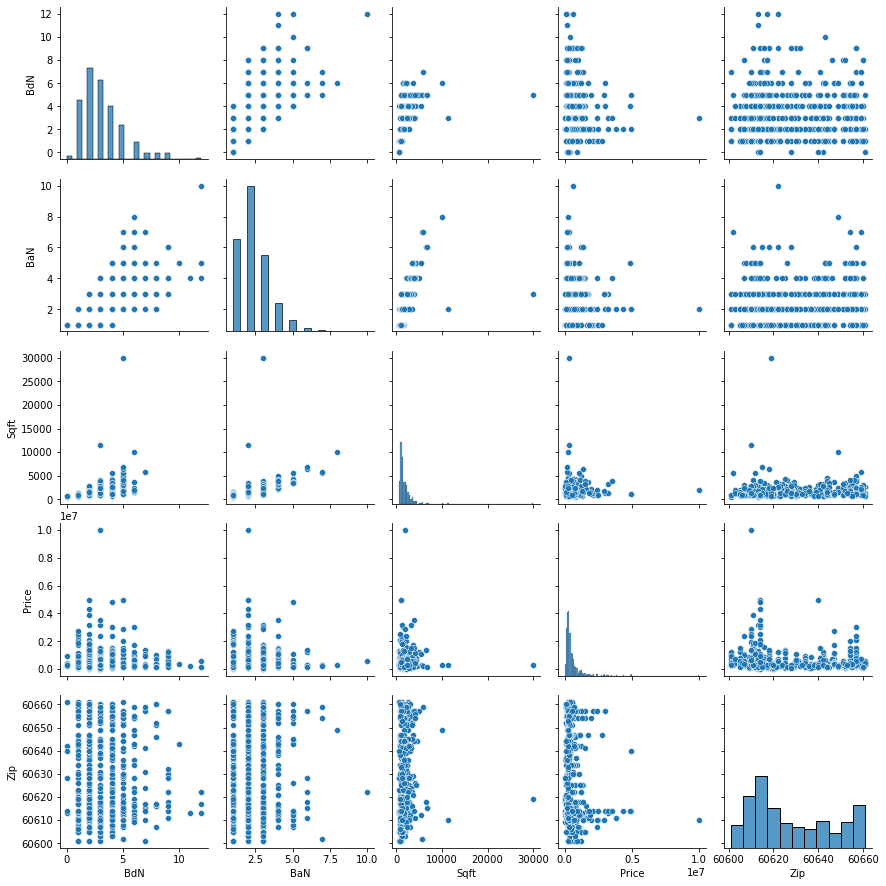

In [4]:
sns.pairplot(df)

<AxesSubplot:>

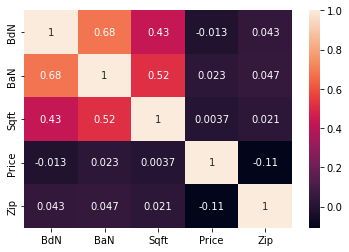

In [5]:
sns.heatmap(df.corr(), annot = True)

In [6]:
df.iplot(kind = "scatter", x = "Sqft", y = "Price", mode = "markers", xTitle = "Sqft", yTitle = "Price")

In [7]:
df.iplot(kind = "scatter", x = "BdN", y = "Price", mode = "markers", xTitle = "Number of Bedrooms", yTitle = "Price")

In [8]:
df.iplot(kind = "scatter", x = "BaN", y = "Price", mode = "markers", xTitle = "Number of Bathrooms", yTitle = "Price")

In [9]:
df["Zip"][df["Price"].idxmax()]
# This is the zip code for the most expensive listing: it is a pricey zip code, with neighborhoods like Old Town and Near North Side

60610

In [10]:
df.groupby("BdN").count()
# looks like bed rooms above 7 drop off in sqft. Lets explore the trend of listings without sqft

,BaN,Sqft,Price,Zip
BdN,,,,
0,6,4,6,6
1,98,69,98,98
2,151,108,151,151
3,131,107,131,131
4,88,59,88,88
5,56,35,56,56
6,29,8,29,29
7,11,1,11,11
8,10,0,10,10


In [11]:
# creating dummy variable for sqft: Nan gets 0
def target(row):
    if row["Sqft"] >= 0:
        return 1
    else:
        return 0
df["sqdummy"] = df.apply(lambda row:target(row), axis = 1)

Text(0.5, 1.0, 'Mean Listing Price')

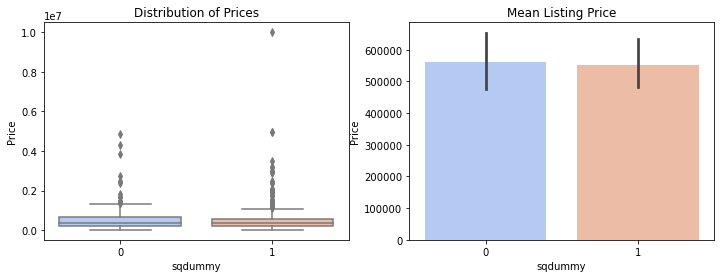

In [12]:
fig,axes = plt.subplots(ncols = 2, figsize = (12,4))
sns.boxplot(ax = axes[0], x = "sqdummy", y = "Price", data = df, palette = "coolwarm")
sns.barplot(ax = axes[1], x = "sqdummy", y = "Price", data = df, palette = "coolwarm")
axes[0].set_title("Distribution of Prices")
axes[1].set_title("Mean Listing Price")

In [13]:
st.pearsonr(df["sqdummy"],df["Price"])
# looks like there is no relationship between having no sqft posted and price

(-0.005343099891497824, 0.8965196914305449)

<AxesSubplot:xlabel='sqdummy', ylabel='count'>

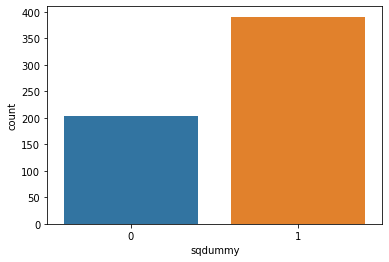

In [14]:
sns.countplot(x = "sqdummy", data = df)

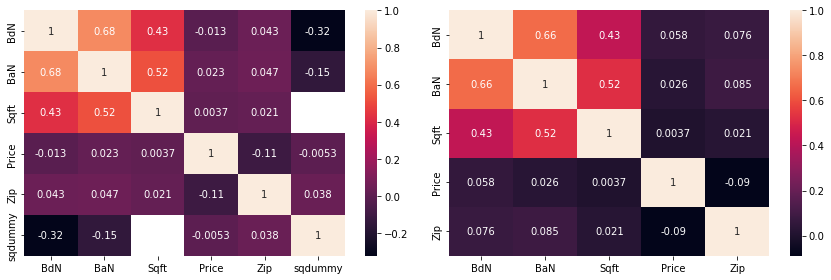

In [15]:
# lets drop the nan values from sqft and see if there are any other trends
fig,axes = plt.subplots(ncols = 2, figsize = (12,4))
sns.heatmap(df.corr(), annot = True, ax = axes[0])
sns.heatmap(df.dropna().drop("sqdummy",axis = 1).corr(),annot=True, ax = axes[1])
plt.tight_layout()

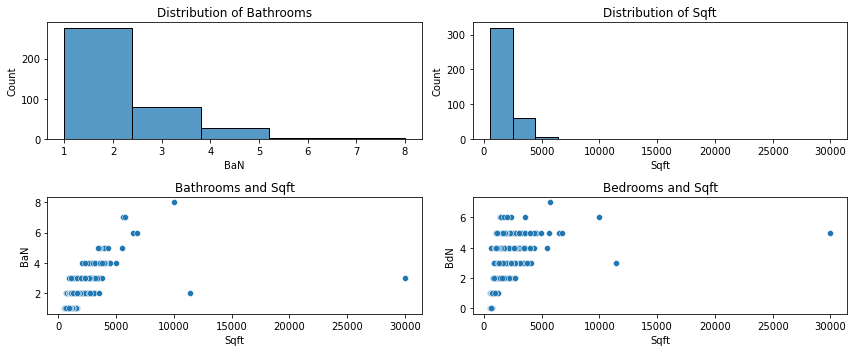

In [16]:
# highest correlation with Sqft seems to be number of bathrooms and number of bedrooms
dropdf = df.dropna().drop("sqdummy",axis = 1)
fig, axes = plt.subplots(figsize = (12,5), ncols = 2, nrows = 2)
sns.histplot( x = "BaN", data = dropdf,ax = axes[0,0], bins = 5)
axes[0,0].set_title("Distribution of Bathrooms")
sns.histplot(x = "Sqft", data = dropdf,ax = axes[0,1], bins = 15)
axes[0,1].set_title("Distribution of Sqft")
sns.scatterplot( x = "Sqft", y = "BaN", data = dropdf, ax =axes [1,0])
axes[1,0].set_title("Bathrooms and Sqft")
sns.scatterplot( x = "Sqft", y = "BdN", data = dropdf, ax =axes [1,1])
axes[1,1].set_title("Bedrooms and Sqft")
plt.tight_layout()

In [17]:
basq = st.pearsonr(dropdf["Sqft"],dropdf["BaN"])
bdsq = st.pearsonr(dropdf["Sqft"],dropdf["BdN"])
print("Bathroom and Sqft Correlation:",bdsq[0],"P Val:",bdsq[1])
print("Bedroom and Sqft Correlation:",bdsq[0],"P Val:",bdsq[1])

Bathroom and Sqft Correlation: 0.42625689306604053 P Val: 1.0818366253102507e-18
Bedroom and Sqft Correlation: 0.42625689306604053 P Val: 1.0818366253102507e-18


In [18]:
# Average Sqft per Bathroom Dist
#1 - 2 Bathrooms
onetwo = dropdf[(dropdf["BaN"]==1)|(dropdf["BaN"]==2)]["Sqft"].mean()
threefour = dropdf[(dropdf["BaN"]==3)|(dropdf["BaN"]==4)]["Sqft"].mean()
fivemore = dropdf[dropdf["BaN"]>=5]["Sqft"].mean()

In [19]:
# Lets fill in the nan sqft using the average sqft of matching number of bathrooms
def simple_sq (cols):
    Sqft = cols[0]
    BaN = cols[1]
    
    if pd.isnull(Sqft):
        if BaN >= 1 and BaN <=2:
            return onetwo
        elif BaN >= 3 and BaN <=4:
            return threefour
        else:
            return fivemore
    else:
        return Sqft 

df["Sqft"] = df[["Sqft","BaN"]].apply(simple_sq, axis = 1)   

In [20]:
# now our sqft is filled with average sqft values using the number of bathrooms
df.head()

,BdN,BaN,Sqft,Price,Zip,sqdummy
0,3,3,3300.000000,3200000,60613,1
1,6,7,5245.833333,274900,60654,0
2,1,1,800.000000,2095000,60614,1
3,5,5,5245.833333,249000,60607,0
4,1,1,875.000000,474900,60607,1


In [21]:
###########################################

In [22]:
###########################################

In [56]:
# Linear Regression Model to predict list prices
X = df.drop(["Price","sqdummy"], axis = 1)
y = df["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lm = LinearRegression()
lm.fit(X_train,y_train)
pd.DataFrame(lm.coef_, X_train.columns,columns = ["Coeff"])

,Coeff
BdN,-33304.914494
BaN,60077.374426
Sqft,-5.839629
Zip,-5336.779348


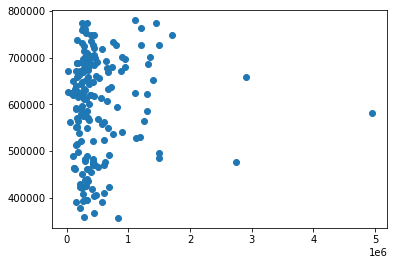

In [57]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)

In [58]:
# MAE
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_test,predictions))
# MSE
print("MSE:",metrics.mean_squared_error(y_test,predictions))
# RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions)))
# R RMSE
print("R RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions))/df["Price"].mean())
# R2 Score
from sklearn.metrics import r2_score
print("R2:",r2_score(y_test,predictions))
# Pearson R and P Value
print("R:",st.pearsonr(y_test,predictions)[0],", P Val:",st.pearsonr(y_test,predictions)[1])

MAE: 359832.79688061815
MSE: 299974864517.6618
RMSE: 547699.6115734078
R RMSE: 0.987192262909183
R2: -0.0355192314264432
R: 0.07780461327219852 , P Val: 0.30056044606149573


<AxesSubplot:xlabel='Price', ylabel='Count'>

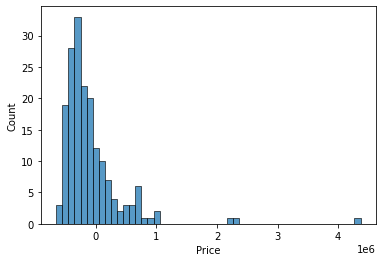

In [59]:
sns.histplot((y_test-predictions), bins = 50)

In [60]:
# Will getting rid of the Zip help?
X = df.drop(["sqdummy","Price","Zip"], axis = 1)
y = df["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
# MAE
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_test,predictions))
# MSE
print("MSE:",metrics.mean_squared_error(y_test,predictions))
# RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions)))
# R RMSE
print("R RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions))/df["Price"].mean())
# R2 Score
from sklearn.metrics import r2_score
print("R2:",r2_score(y_test,predictions))
# Pearson R and P Value
print("R:",st.pearsonr(y_test,predictions)[0],", P Val:",st.pearsonr(y_test,predictions)[1])

MAE: 430275.64874718443
MSE: 547637971547.86694
RMSE: 740025.656006511
R RMSE: 1.3338472157488566
R2: -0.015409997389634
R: 0.008639121129570007 , P Val: 0.9086227120141367


In [61]:
# Okay, it looks like we cannot predict the price of the houses in Chicago very well. 
# However, lets see if we can predict the number of bedrooms
X = df.drop(["sqdummy","BdN"], axis = 1)
y = df["BdN"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lm = LinearRegression()
lm.fit(X_train,y_train)
pd.DataFrame(lm.coef_, X_train.columns,columns = ["Coeff"])

,Coeff
BaN,1.090391e+00
Sqft,2.200171e-05
Price,-3.775316e-08
Zip,2.401418e-04


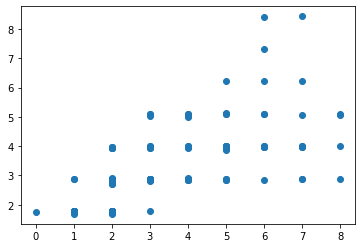

In [62]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)

In [63]:
# MAE
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_test,predictions))
# MSE
print("MSE:",metrics.mean_squared_error(y_test,predictions))
# RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions)))
# R RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions))/df["BdN"].mean())
# R2 Score
from sklearn.metrics import r2_score
print("R2:",r2_score(y_test,predictions))
# Pearson R and P Value
print("R:",st.pearsonr(y_test,predictions)[0],", P Val:",st.pearsonr(y_test,predictions)[1])

MAE: 1.0162187627206622
MSE: 1.7867691263154644
RMSE: 1.3367008365058595
RMSE: 0.4179385169316796
R2: 0.4550641590714293
R: 0.6746084591629271 , P Val: 4.0710731243508006e-25


<AxesSubplot:xlabel='BdN', ylabel='Count'>

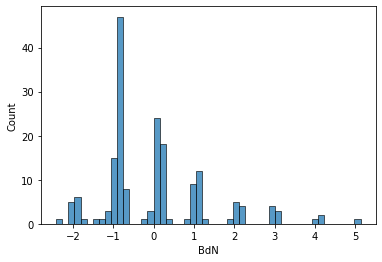

In [64]:
sns.histplot((y_test-predictions), bins = 50)

In [65]:
# Will getting rid of the Zip help?
X = df.drop(["sqdummy","BdN","Zip"], axis = 1)
y = df["BdN"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
# MAE
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_test,predictions))
# MSE
print("MSE:",metrics.mean_squared_error(y_test,predictions))
# RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions)))
# R RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions))/df["BdN"].mean())
# R2 Score
from sklearn.metrics import r2_score
print("R2:",r2_score(y_test,predictions))
# Pearson R and P Value
print("R:",st.pearsonr(y_test,predictions)[0],", P Val:",st.pearsonr(y_test,predictions)[1])

MAE: 1.1211262551875654
MSE: 2.3447159755430946
RMSE: 1.5312465430305777
RMSE: 0.4787659974267965
R2: 0.35404590923462387
R: 0.5969047646704024 , P Val: 1.1639306078186296e-18


In [66]:
# Okay what about predicting the number of bedrooms with data that didn't have sq extracted from bathrooms
X = dropdf.drop(["BdN"], axis = 1)
y = dropdf["BdN"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
# MAE
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_test,predictions))
# MSE
print("MSE:",metrics.mean_squared_error(y_test,predictions))
# RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions)))
# R RMSE
print("R RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions))/df["BdN"].mean())
# R2 Score
from sklearn.metrics import r2_score
print("R2:",r2_score(y_test,predictions))
# Pearson R and P Value
print("R:",st.pearsonr(y_test,predictions)[0],", P Val:",st.pearsonr(y_test,predictions)[1])

MAE: 0.8416835381315845
MSE: 0.9960865824852685
RMSE: 0.9980413731330322
R RMSE: 0.3120518218676585
R2: 0.4621093824112904
R: 0.6813573305057974 , P Val: 2.0471961772217828e-17


In [67]:
# Lets Drop Zip from the model
X = dropdf.drop(["BdN", "Zip"], axis = 1)
y = dropdf["BdN"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
# MAE
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_test,predictions))
# MSE
print("MSE:",metrics.mean_squared_error(y_test,predictions))
# RMSE
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions)))
# R RMSE
print("R RMSE:",np.sqrt(metrics.mean_squared_error(y_test,predictions))/df["BdN"].mean())
# R2 Score
from sklearn.metrics import r2_score
print("R2:",r2_score(y_test,predictions))
# Pearson R and P Value
print("R:",st.pearsonr(y_test,predictions)[0],", P Val:",st.pearsonr(y_test,predictions)[1])

MAE: 0.8729764856414445
MSE: 1.1687406503020763
RMSE: 1.0810830913033818
R RMSE: 0.33801599544167743
R2: 0.3652320936612665
R: 0.6219113950762045 , P Val: 5.6414852872105825e-14
